In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./input/train.csv
./input/test.csv
./input/digit-recognizer.zip
./input/sample_submission.csv


In [2]:
import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv('./input/train.csv')
test_data = pd.read_csv('./input/test.csv')
print(train_data.shape)
print(test_data.shape)


(42000, 785)
(28000, 784)


In [4]:
train_data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train = train_data.iloc[:,1:].values.reshape(-1, 1, 28, 28)
y_train = train_data.iloc[:,:1].values.flatten()
X_test = test_data.values.reshape(-1, 1, 28, 28)

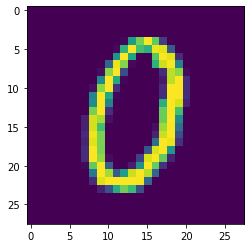

In [6]:
plt.imshow(X_train[5].reshape(28, 28, 1));

In [7]:
y_train[5]
X_train[5].shape

(1, 28, 28)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
transform_conv = transforms.Compose([
    transforms.RandomHorizontalFlip(),# transforms.RandomHorizontalFlip()为水平翻转
    transforms.RandomVerticalFlip(),  # transforms.RandomHorizontalFlip()为上下翻转
    transforms.RandomRotation(15),    # 随机旋转了-15°至15°
    transforms.ToTensor(),
    #transforms.RandomRotation([90, 180, 270]), # 或者自定义旋转了90°, 180°, 270°
    transforms.Resize([32, 32]), # 转化到32*32
    transforms.RandomCrop([28, 28]) # 先旋转了15°，转换成32*32，再取28*28部分
])

In [10]:
class MnistData(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

In [11]:
X_train = torch.tensor(X_train, dtype=torch.float32) / 255
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test, dtype=torch.float32) / 255

In [12]:
train_set = MnistData(X_train, y_train)
test_set = MnistData(X_test)

In [13]:
train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(test_set, batch_size=100)

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        ##Conv Layer
        self.ConvLayers = nn.Sequential(
            #Block 1
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,5), stride=2, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            #Block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(5,5), stride=2, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),  
        )
        
        ##FC Layer
        self.LinearLayers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4608, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 10),
        )
        
        ##Optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=0.003)
        
        ## LR scheduler
        self.exp_lr_scheduler = lr_scheduler.StepLR(self.optimizer, step_size=3, gamma=0.5)
        #self.exp_lr_scheduler = lr_scheduler.ExponentialLR(self.optimizer, gamma=0.1)
        self.train_lr = []

    def forward(self, x):
        output = self.ConvLayers(x)
        output = self.LinearLayers(output)
           
        return F.log_softmax(output, dim=1)
    
    # This is not a typical way to create a train function
    # I like to embed into the model class itself
    def fit(self, train_loader, epochs=1):
        # Turn to train mode
        self.train()
        for epoch in range(epochs):
            # Get loss and accuracy per epoch
            total_loss = 0
            total_acc = 0
            
            train_running_lr = self.optimizer.param_groups[0]['lr']
            
            for batch_idx, (data, target) in enumerate(train_loader):
                data = data.cuda()
                target = target.cuda()
                # Zero grad
                self.optimizer.zero_grad()
                # Get the output
                output = self(data)
                # Calculate the loss (It is average by default)
                loss = F.nll_loss(output, target)
                # Do gradient math
                loss.backward()
                self.optimizer.step()
                # Calculate accuracy and sum over batches
                acc = (output.argmax(1) == target).cpu().numpy().mean()
                total_loss += loss.item()
                total_acc += acc
            
            # Averaging over batch or it will be wrong
            total_loss = total_loss / (batch_idx+1)
            total_acc = total_acc / (batch_idx+1)
            self.train_lr.append(train_running_lr)
            self.exp_lr_scheduler.step()
            print(f"Train Epoch: {epoch}\tLoss: {total_loss:.6f}\tAccuracy: {total_acc:.6f}")

In [15]:
model = CNN().cuda()

In [16]:
model.fit(train_loader, epochs=15)

Train Epoch: 0	Loss: 0.100777	Accuracy: 0.969500
Train Epoch: 1	Loss: 0.038127	Accuracy: 0.988190
Train Epoch: 2	Loss: 0.026058	Accuracy: 0.992071
Train Epoch: 3	Loss: 0.013344	Accuracy: 0.996214
Train Epoch: 4	Loss: 0.006536	Accuracy: 0.997929
Train Epoch: 5	Loss: 0.004086	Accuracy: 0.998929
Train Epoch: 6	Loss: 0.001894	Accuracy: 0.999548
Train Epoch: 7	Loss: 0.000676	Accuracy: 0.999905
Train Epoch: 8	Loss: 0.000250	Accuracy: 0.999976
Train Epoch: 9	Loss: 0.000143	Accuracy: 1.000000
Train Epoch: 10	Loss: 0.000114	Accuracy: 1.000000
Train Epoch: 11	Loss: 0.000097	Accuracy: 1.000000
Train Epoch: 12	Loss: 0.000082	Accuracy: 1.000000
Train Epoch: 13	Loss: 0.000075	Accuracy: 1.000000
Train Epoch: 14	Loss: 0.000067	Accuracy: 1.000000


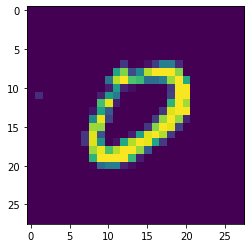

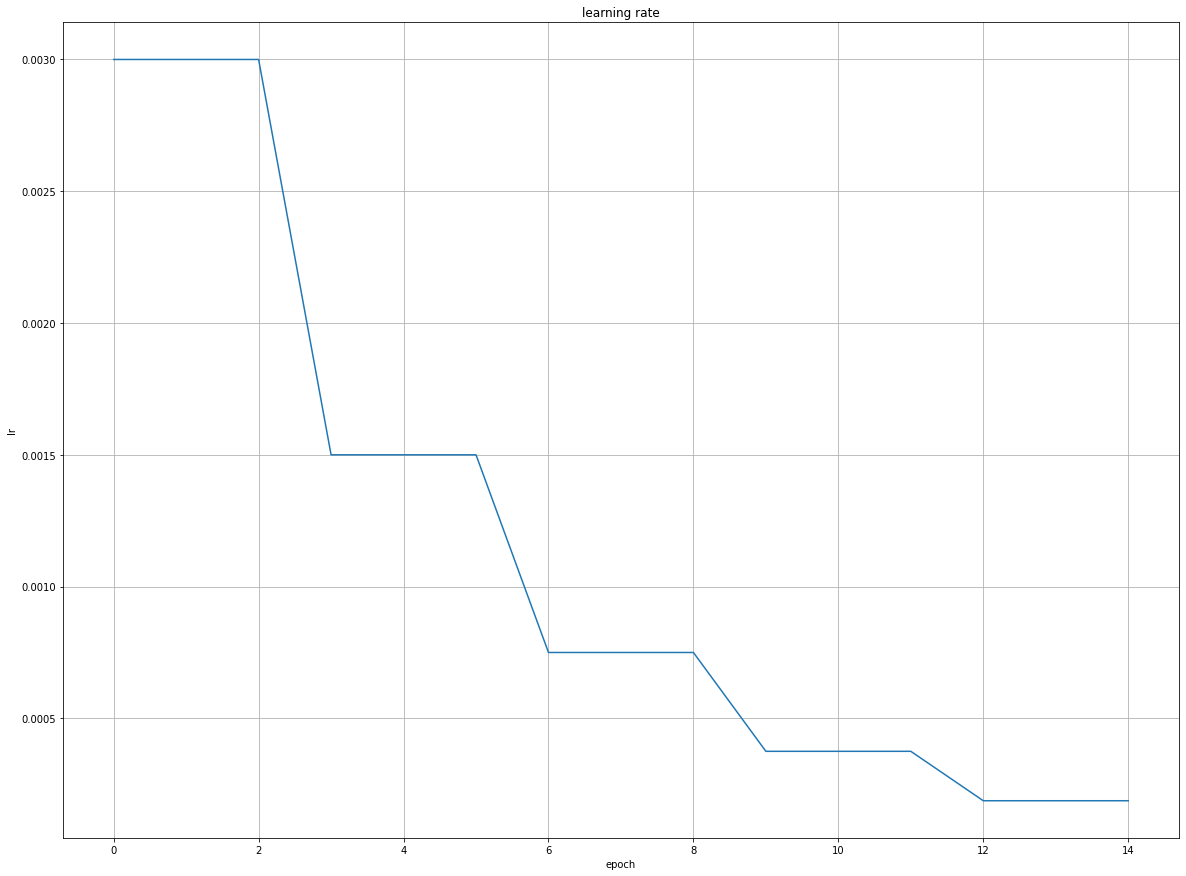

In [17]:
plt.imshow(X_test[3].reshape(28, 28, 1));

plt.figure(figsize = (20,15))
plt.plot(model.train_lr)
plt.title('learning rate')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.grid()
    
plt.show()

In [18]:
for batch_idx, (data) in enumerate(test_loader):
    data = data.cuda()

    test_outputs = model(data)
    _, predicted = torch.max(test_outputs, 1)

    df = pd.DataFrame(predicted.cpu().numpy())
    if (0 == batch_idx):
        results = df
    else:
        results = results.append(df, ignore_index=True)

results.insert(results.shape[1], 'ImageId', results.index+1)
results.columns = ['Label', 'ImageId']


In [19]:
order = ['ImageId', 'Label']
results = results[order]

results.to_csv('submission.csv', index=None)

In [20]:
model

CNN(
  (ConvLayers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3))
    (16): ReLU()
    (17): BatchNorm2d(128, 